# Parent and Progeny Correlations
Code to plot correlation and count division times from separation, then color spots that way. 
The df we create is similar to the Random Forest DF (without ruby features) but for ease of reading and making sure nothing gets mixed up these are in separate notebooks. 

In [1]:
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score



# makes figures look better in Jupyter
sns.set_context('talk')
sns.set_style("ticks")
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Prepping DF

In [2]:
plot_output = '/Volumes/salmonella/users/madison/2024_DIMM_MultirepAnalysis/LineagePlotting/Final_Plots'
df_slope = pd.read_csv(os.path.join(plot_output, 'slope_df_final.csv'))

In [77]:
df_slope_switch = df_slope[df_slope['category']=='switch']
df_slope_switch_no_mothers = df_slope_switch[df_slope_switch['parent']!=0]
df_final = df_slope_switch_no_mothers.dropna(subset=['parent_start_inc'])
df_final['parent_start_inc_div_norm'] = df_final['parent_start_inc']-df_final['appearance_time']
df_final['start_inc_div_norm'] = df_final['start_inc']-df_final['appearance_time']
len(df_final)

/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/892283200.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['parent_start_inc_div_norm'] = df_final['parent_start_inc']-df_final['appearance_time']
/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/892283200.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['start_inc_div_norm'] = df_final['start_inc']-df_final['appearance_time']


633

In [82]:
df_30min = df_final[df_final['start_inc'] > df_final['appearance_time']+30]
df_filtered = df_30min[df_30min['parent_start_inc_div_norm']>0]
print(len(df_30min))
print(len(df_filtered))

455
436


/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/2189816762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['appearance_to_start'] = df_final['start_inc'] - df_final['appearance_time']


R^2 Score: 0.6250968462725659


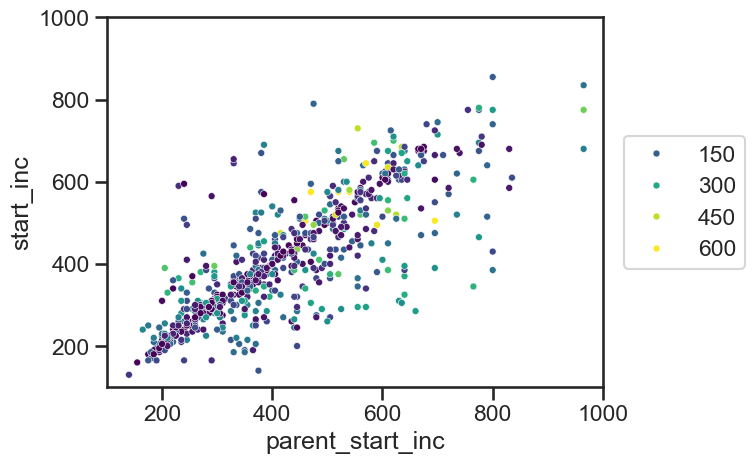

In [7]:
#Plot the raw to see how it looks
df_final['appearance_to_start'] = df_final['start_inc'] - df_final['appearance_time']
ax = sns.scatterplot(data=df_final, x='parent_start_inc', y='start_inc', s =25, alpha = 1, hue= df_final['appearance_to_start'], palette = 'viridis', hue_norm =(0,500) ) 
ax.set_xlim(100,1000)
ax.set_ylim(100, 1000)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
print("R^2 Score:", r2_score(df_final['parent_start_inc'], df_final['start_inc']))

/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/1751154719.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['parent_start_inc_div_norm'] = df_final['parent_start_inc']-df_final['appearance_time']
/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/1751154719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['start_inc_div_norm'] = df_final['start_inc']-df_final['appearance_time']
No artists with labels found to put in legend.  Note that artists whose label 

R^2 Score: 0.6132958808829336


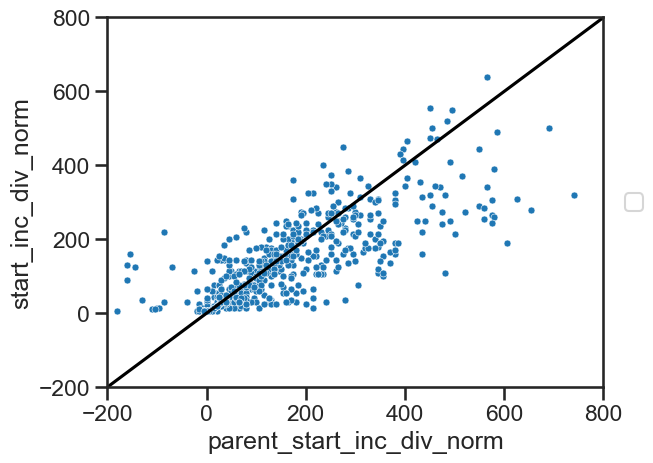

In [8]:
#Normalize by the time of division and plot
df_final['parent_start_inc_div_norm'] = df_final['parent_start_inc']-df_final['appearance_time']
df_final['start_inc_div_norm'] = df_final['start_inc']-df_final['appearance_time']
ax = sns.scatterplot(data=df_final, x='parent_start_inc_div_norm', y='start_inc_div_norm', s =25, alpha = 1) 
x1 = np.array([-200, 800])
y1 = 1 * x1 + 0
ax.set_xlim(-200,800)
ax.set_ylim(-200, 800)
plt.plot(x1, y1, "black")
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
print("R^2 Score:", r2_score(df_final['parent_start_inc_div_norm'], df_final['start_inc_div_norm']))

In [12]:
def count_sibling_appearances(row, df):
    # Filter sibling rows: same ID and parent, different cell
    siblings = df[
        (df['unique_ID'] == row['unique_ID']) &
        (df['parent'] == row['parent']) &
        (df['cell_id'] != row['cell_id'])
    ]
    
    # Count how many sibling appearance times fall between X and Y
    count = siblings['appearance_time'].between(row['parent_start_inc'], row['start_inc']).sum()
    return count

# Apply the function to each row
df_final['interim_mother_divisions'] = df_final.apply(lambda row: count_sibling_appearances(row, df_final), axis=1)

df_final

/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/3117164033.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['interim_mother_divisions'] = df_final.apply(lambda row: count_sibling_appearances(row, df_final), axis=1)


,Unnamed: 0,unique_ID,experiment,position,track,cell_id,parent,max_slope,appearance_time,time_of_max_slope,...,duration,magnitude_inc,category,long_enough_time,parent_start_inc,appearance_to_start,parent_start_inc_div_norm,start_inc_div_norm,interim_daughter_appearances,interim_mother_divisions
6,6,20240809__XY02_crop2__Track_20,20240809,XY02_crop2,Track_20,2,1,0.110562,540,560.0,...,190.0,1.446176,switch,True,550.0,10.0,10.0,10.0,0,0
10,10,20240809__XY02_crop3__Track_8,20240809,XY02_crop3,Track_8,2,1,0.170125,360,395.0,...,80.0,1.245123,switch,True,385.0,30.0,25.0,30.0,0,0
16,16,20240809__XY10_crop13__Track_4,20240809,XY10_crop13,Track_4,2,1,0.232434,45,245.0,...,150.0,2.565122,switch,True,310.0,190.0,265.0,190.0,0,0
17,17,20240809__XY10_crop13__Track_4,20240809,XY10_crop13,Track_4,3,2,0.165743,210,240.0,...,95.0,1.543360,switch,True,235.0,25.0,25.0,25.0,0,0
18,18,20240809__XY10_crop13__Track_4,20240809,XY10_crop13,Track_4,4,1,0.200909,215,270.0,...,80.0,1.631671,switch,True,310.0,40.0,95.0,40.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5214,5214,20241028__XY29_crop6__Track_3,20241028,XY29_crop6,Track_3,6,1,0.220583,490,635.0,...,120.0,1.822145,switch,True,630.0,140.0,140.0,140.0,0,0
5216,5216,20241028__XY29_crop6__Track_3,20241028,XY29_crop6,Track_3,8,4,0.142128,630,715.0,...,120.0,1.697684,switch,True,780.0,80.0,150.0,80.0,0,0
5217,5217,20241028__XY29_crop6__Track_3,20241028,XY29_crop6,Track_3,9,5,0.126805,640,745.0,...,145.0,2.046562,switch,True,680.0,100.0,40.0,100.0,0,0
5218,5218,20241028__XY29_crop6__Track_3,20241028,XY29_crop6,Track_3,10,2,0.166125,645,845.0,...,150.0,2.303126,switch,True,965.0,190.0,320.0,190.0,0,0


R^2 Score: 0.6132958808829336


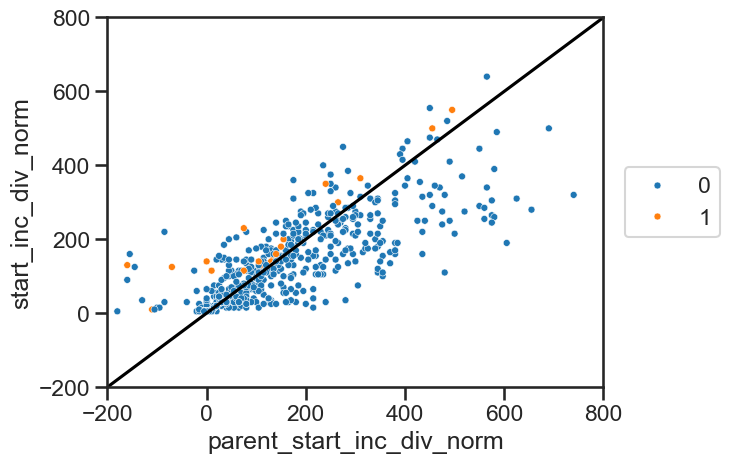

In [11]:
ax = sns.scatterplot(data=df_final, x='parent_start_inc_div_norm', y='start_inc_div_norm', s =25, hue = 'interim_daughter_appearances', alpha = 1) 
x1 = np.array([-200, 800])
y1 = 1 * x1 + 0
ax.set_xlim(-200,800)
ax.set_ylim(-200, 800)
plt.plot(x1, y1, "black")
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
print("R^2 Score:", r2_score(df_final['parent_start_inc_div_norm'], df_final['start_inc_div_norm']))

In [16]:
def count_child_appearances_in_range(row, df):
    # Step 1: Filter children of the current cell_ID within the same unique_ID
    children = df[
        (df['unique_ID'] == row['unique_ID']) &
        (df['parent'] == row['cell_id'])
    ]
    
    # Step 2: Count how many children's appearance times fall within X and Y
    return children['appearance_time'].between(row['parent_start_inc'], row['start_inc']).sum()

df_final['interim_daughter_divisions'] = df_final.apply(lambda row: count_child_appearances_in_range(row, df_final), axis=1)
df_final['total_interim_divisions'] = df_final['interim_daughter_divisions']+df_final['interim_mother_divisions']

/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/3650973986.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['interim_daughter_divisions'] = df_final.apply(lambda row: count_child_appearances_in_range(row, df_final), axis=1)
/var/folders/46/k335xc3d451dkz01yv9q72sc0000gr/T/ipykernel_9593/3650973986.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['total_interim_divisions'] = df_final['interim_daughter_divisions']+df_final['interim_mother_divisions']


R^2 Score: 0.6132958808829336


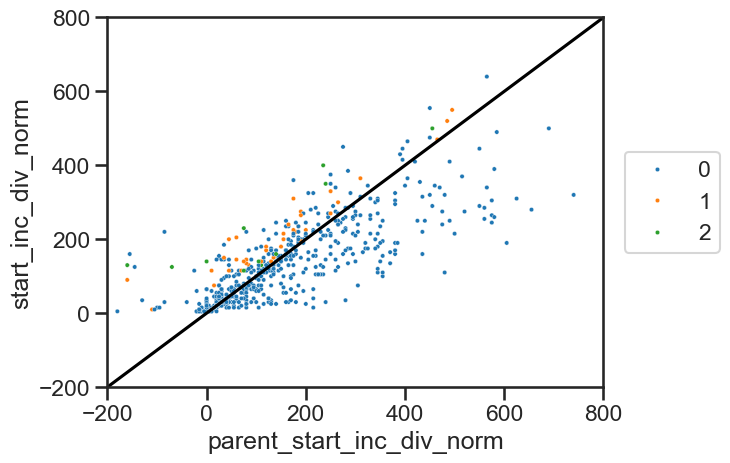

In [22]:
ax = sns.scatterplot(data=df_final, x='parent_start_inc_div_norm', y='start_inc_div_norm', s =10, hue = 'total_interim_divisions', alpha = 1, palette = 'tab10') 
x1 = np.array([-200, 800])
y1 = 1 * x1 + 0
ax.set_xlim(-200,800)
ax.set_ylim(-200, 800)
plt.plot(x1, y1, "black")
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
print("R^2 Score:", r2_score(df_final['parent_start_inc_div_norm'], df_final['start_inc_div_norm']))

(-200.0, 800.0)

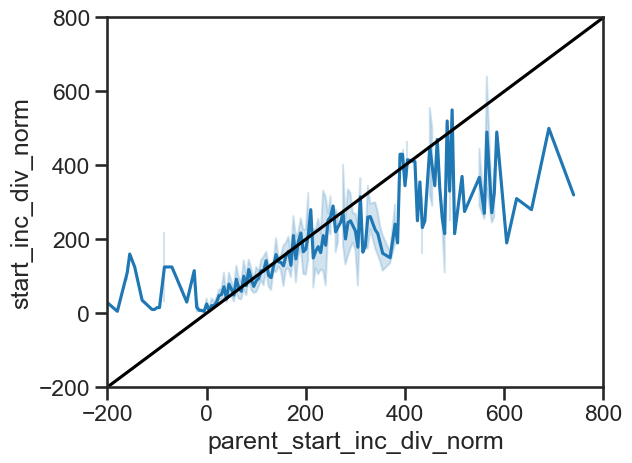

In [31]:
ax = sns.lineplot(data=df_final, x='parent_start_inc_div_norm', y='start_inc_div_norm') 
plt.plot(x1, y1, "black")
ax.set_xlim(-200,800)
ax.set_ylim(-200, 800)

R-squared (vs. perfect y=x): 0.1069897948302948


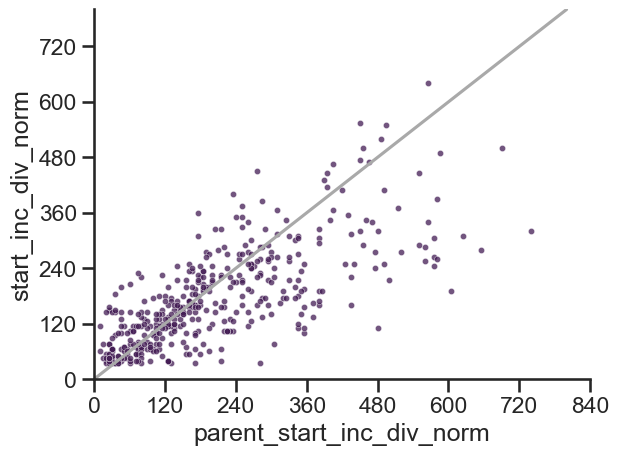

In [106]:
ax = sns.scatterplot(data=df_filtered, x='parent_start_inc_div_norm', y='start_inc_div_norm', color = '#431c54', s=20, alpha= 0.75) 

y_perfect = df_filtered['parent_start_inc_div_norm']
y_test = df_filtered['start_inc_div_norm']
y_mean = df_filtered['start_inc_div_norm'].mean()

ss_total = np.sum((y_test - y_mean)**2)

ss_residual = np.sum((y_test - y_perfect)**2)

# Calculate R-squared
r_squared = 1 - (ss_residual / ss_total)

print(f"R-squared (vs. perfect y=x): {r_squared}")
plt.plot(x1, y1, "darkgrey")
ax.set_xlim(0,800)
ax.set_xticks([0, 120, 240, 360, 480, 600, 720, 840])
ax.set_yticks([0, 120, 240, 360, 480, 600, 720, 840])

ax.set_ylim(0, 800)
sns.despine()
plt.savefig(plot_output +'/final_parent_vs_prog.pdf',bbox_inches='tight', transparent=True)

In [91]:
accuracy_df = pd.DataFrame({'Experimental': y_test, 'Predicted': y_perfect, 'X':df_filtered['parent_start_inc_div_norm'] })
accuracy_df['individual_acc']= abs((accuracy_df['Predicted']-accuracy_df['Experimental'])/accuracy_df['Experimental'])
accuracy_df['individual_acc_percent'] = accuracy_df['individual_acc']*100
accuracy = 1-(1/len(accuracy_df) * accuracy_df['individual_acc'].sum()) 
print(accuracy_df['individual_acc'].mean())
print(accuracy_df['individual_acc'].std())
print(accuracy)
accuracy_df

0.49083569351744394
0.6485476229244193
0.5091643064825561


,Experimental,Predicted,X,individual_acc,individual_acc_percent
16,190.0,265.0,265.0,0.394737,39.473684
18,40.0,95.0,95.0,1.375000,137.500000
59,180.0,120.0,120.0,0.333333,33.333333
80,220.0,80.0,80.0,0.636364,63.636364
89,160.0,435.0,435.0,1.718750,171.875000
...,...,...,...,...,...
5213,215.0,500.0,500.0,1.325581,132.558140
5214,140.0,140.0,140.0,0.000000,0.000000
5216,80.0,150.0,150.0,0.875000,87.500000
5217,100.0,40.0,40.0,0.600000,60.000000


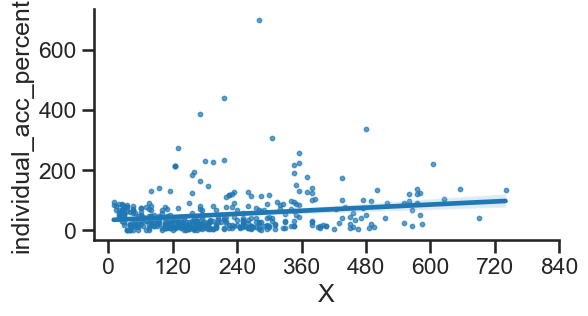

In [113]:
plt.figure(figsize=(6, 3))
ax = sns.regplot(data=accuracy_df, x='X', y='individual_acc_percent', scatter_kws={'s': 10,  'alpha': 0.7}) 
ax.set_xticks([0, 120, 240, 360, 480, 600, 720, 840])
sns.despine()
plt.savefig(plot_output +'/final_parent_vs_prog_accovertime.pdf',bbox_inches='tight', transparent=True)

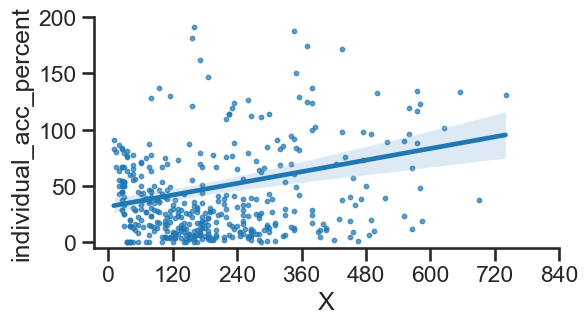

In [114]:
plt.figure(figsize=(6, 3))
ax = sns.regplot(data=accuracy_df, x='X', y='individual_acc_percent', scatter_kws={'s': 10, 'alpha': 0.7}) 
ax.set_xticks([0, 120, 240, 360, 480, 600, 720, 840])
ax.set_ylim(-5, 200)
sns.despine()
plt.savefig(plot_output +'/final_parent_vs_prog_accovertime_zoom.pdf',bbox_inches='tight', transparent=True)

(-5.0, 100.0)

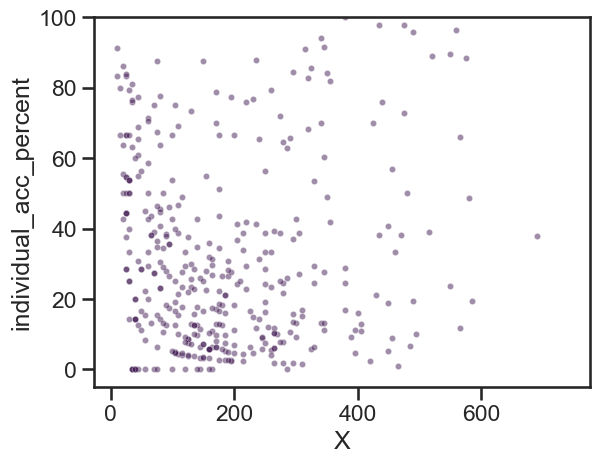

In [95]:
ax = sns.scatterplot(data=accuracy_df, x='X', y='individual_acc_percent', color = '#431c54', s=20, alpha= 0.5) 
ax.set_ylim(-5, 100)

In [85]:
residuals = y_test - y_perfect

# Calculate MSE
mse = np.mean(residuals**2)

# Calculate RMSE (if preferred)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 10242.88990825688
RMSE: 101.20716332482044


(-200.0, 800.0)

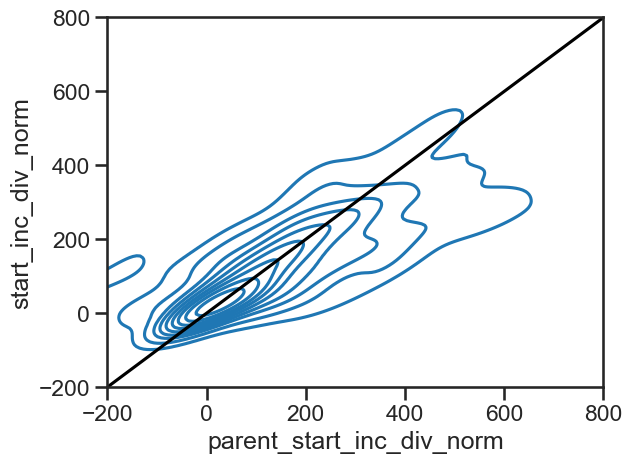

In [33]:
ax = sns.kdeplot(data=df_final, x='parent_start_inc_div_norm', y='start_inc_div_norm') 
plt.plot(x1, y1, "black")


<Axes: xlabel='parent_start_inc_div_norm', ylabel='start_inc_div_norm'>

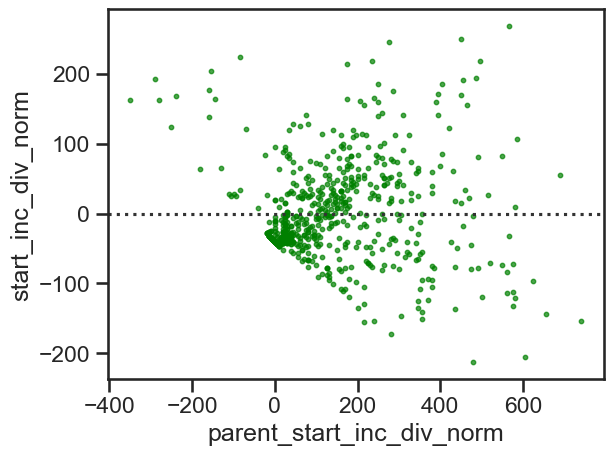

In [49]:
sns.residplot(data=df_final, x='parent_start_inc_div_norm', y='start_inc_div_norm', scatter_kws={'s': 10, 'color': 'green', 'alpha': 0.7})